In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

from jax import jit, value_and_grad
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
from readin_data_runs import get_cached_data_once_digital,save_cached_data, process_new_files_digital

num_epochs = 1500
# # Process files by each N_ctrl and update the cache independently
# cached_data_analog_nctrl3 , processed_files_analog_nctrl3 = get_cached_data_direct_path(nctrl3_path, N_ctrl)
# Main loop for different N_ctrl values
N_ctrls = [1, 2,3]
num_train = 30
reservoir_counts = [1, 2, 3]
processed_files_global_digital = set()
# base_path = f'/Users/sophieblock/QRCCapstone/gate_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_opt/'
# base_path = f'/Users/sophieblock/QRCCapstone/digital_res2/trainsize_{num_train}_epoch1500_per_param_costcut_1e-8/'
base_path = f'/Users/sophieblock/QRCCapstone/digital_qfim_res/trainsize_{num_train}_epoch1500_per_param_costcut_1e-8/'
# base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_costcut_1e-10/'

cached_data_digital, processed_files_digital = get_cached_data_once_digital(base_path)
print(cached_data_digital.keys())


[INFO] Cache file /Users/sophieblock/QRCCapstone/digital_qfim_res/trainsize_30_epoch1500_per_param_costcut_1e-8/cached_results.pkl does not exist. Creating empty cache.
dict_keys([])


In [9]:
trots = [1,2, 3, 4,  6, 7,8]
trots = [9]
reservoir_counts = [1]
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    



    # Process files and update the cache
    cached_data_digital, processed_files_digital = process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data_digital, processed_files_digital, N_ctrl)

    save_cached_data(base_path, cached_data_digital, processed_files_digital)
    processed_files_global_digital.update(processed_files_digital)

[process_new_files_digital] Processing for N_ctrl = 1
[process_new_files_digital] Processing for N_ctrl = 2
[process_new_files_digital] U2_0, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_1, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_10, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_11, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_12, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_13, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_14, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_15, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_16, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_17, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_18, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files_digital] U2_19, N_c=2, N_R=1, T=9, num files(runs)= 1
[process_new_files

In [10]:

cached_data_digital_copy = cached_data_digital.copy()

def get_dataframe(cached_data_temp, model_type = "Digital",gate_count_cap = 20,N_ctrls = [2]):
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        original = results.get('test_results', [])
                        new_vals = []
                        for f in original:
                            if f > 1.0:
                                delta = f - 1.0       # how far above 1.0
                                reflected = 1.0 - delta  # reflect about 1.0
                                # If 'reflected' dips below 0 (which can happen if f>2),
                                # you might clamp it to 0.0 or do something else:
                                if reflected < 0:
                                    reflected = 0.0
                                print(f"[PASS 1] Reflecting fidelity {f:.6f} about 1.0 => {reflected:.6f} "
                                    f"(Gate={gate}, N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step})")
                                new_vals.append(reflected)
                            else:
                                new_vals.append(f)
                        results['test_results'] = new_vals
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        # Just clamp any test_results fidelity to <= 1.0
                        original = results.get('test_results', [])
                        clamped_vals = [min(1.0, f) for f in original]
                        results['test_results'] = clamped_vals
                        
    tmp_rows = []
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        row = {
                            'Type': model_type,
                            'N_C': N_ctrl,
                            'Gate': gate,
                            'N_R': reservoir_count,
                            'Trotter_Step': trotter_step,
                        }
                        # Include *all* keys from `results` so we don't drop anything
                        for k, v in results.items():
                            row[k] = v

                        tmp_rows.append(row)

    tmp_df = pd.DataFrame(tmp_rows)
        
   

    def keep_iqr_5_95(arr, a=0, b=95):
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [a, b])
        filtered = [x for x in arr if p5 <= x <= p95]
        return filtered if filtered else arr
    if model_type == "Digital":
        tmp_df['test_results'] = tmp_df['test_results'].apply(keep_iqr_5_95)

    tmp_df['avg_fidelity'] = tmp_df['test_results'].apply(
        lambda arr: np.mean(arr) if len(arr) else 1.0
    )

    group_cols = ['N_C', 'N_R', 'Trotter_Step']
    tmp_df['local_max_avg_fid'] = (
        tmp_df.groupby(group_cols)['avg_fidelity'].transform('max')
    )


    def fix_any_ones_partially(row):
        arr = row['test_results']
        if len(arr) > 0 and any(x == 1.0 for x in arr):
            local_max = row['local_max_avg_fid']
            new_arr = []
            for x in arr:
                if x == 1.0:
                    new_arr.append(local_max)
                else:
                    new_arr.append(x)
            print(f"[PASS 2] Partially replacing any 1.0 entries "
                f"with local_max_avg_fid={local_max:.4e} "
                f"(Gate={row['Gate']}, N_C={row['N_C']}, "
                f"N_R={row['N_R']}, T={row['Trotter_Step']})")
            return new_arr
        return arr
    tmp_df['test_results'] = tmp_df.apply(fix_any_ones_partially, axis=1)

    
    ##############################################################################
    # WRITE BACK THE UPDATED `test_results` INTO `cached_data_temp`
    # so your original code snippet can run unmodified.
    ##############################################################################
    for idx, row in tmp_df.iterrows():
        N_ctrl = row['N_C']
        gate = row['Gate']
        reservoir_count = row['N_R']
        trotter_step = row['Trotter_Step']
        
        # Find matching entry in the results_list
        results_list = cached_data_temp[N_ctrl][gate][reservoir_count][trotter_step]
        found_entry = False
        for results in results_list:
            # If you have a unique 'run' key, match on that
            if 'run' in row and results.get('run') == row['run']:
                results['test_results'] = row['test_results']
                found_entry = True
                break

        # If you have no unique ID, you must figure out a safe way to match
        # For now, we skip if not found:
        if not found_entry:
            pass



    ##############################################################################
    # PASS 2: RUN YOUR ORIGINAL CODE TO BUILD THE FINAL `all_data_df` WITH ALL KEYS
    ##############################################################################
    rows = []
    negative_fidelity_values = []

    global_min_error = 100  # from your snippet
    # N_ctrls = [2,3]        # or whatever your loop over N_ctrl is

    for N_ctrl in N_ctrls:
        data_i = cached_data_temp[N_ctrl]
        for gate, gate_data in data_i.items():
            gate_idx = int(gate.split('_')[-1])
            if gate_idx > gate_count_cap:
                continue
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        avg_fidelity = results.get('fidelity', np.nan)
                        std_fidelity = np.nanstd(results.get('test_results', []))

                        if pd.isna(avg_fidelity):
                            raise ValueError(
                                f"NaN in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                                f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, "
                                f"Run: {results.get('run', None)}"
                            )

                        log_infidelities = []
                        infidelities, fidelities = [], []
                        num_clipped = {}
                        all_og_fidelities = {}

                        test_results = results.get('test_results', [])
                        optimal_min_error = None
                        optimal_jitter_scale = None

                        # Step 1: dynamic min_error + jitter
                        non_clipped_fids = [
                            f for f in test_results
                            if 0 < f < 1.0
                        ]
                        if non_clipped_fids:
                            sorted_valid = sorted(non_clipped_fids)
                            n = len(sorted_valid)
                            std_dev = np.std(sorted_valid)
                            std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                            optimal_min_error = 1.0 - sorted_valid[-1]
                            if global_min_error > optimal_min_error:
                                global_min_error = max(1e-9, optimal_min_error)
                            optimal_jitter_scale = (
                                std_dev / 2
                                if std_dev/2 < optimal_min_error
                                else optimal_min_error
                            )
                        else:
                            optimal_min_error = global_min_error
                            optimal_jitter_scale = global_min_error

                        # Step 2: Process each fidelity
                        clipped_count = 0
                        for i, f in enumerate(test_results):
                            all_og_fidelities[i] = f
                            inf = 1.0 - f

                            if inf <= 1e-8:
                                clipped_count += 1
                                jitter = np.random.uniform(-optimal_jitter_scale, 
                                                        optimal_jitter_scale)
                                num_clipped[i] = {'fidelity': f, 'jit': jitter}
                                inf = optimal_min_error + jitter
                                # print(f'triggered')
                                # print(f"\nGate={results['gate']} => test_results stats:")
                                # print(f"  Min={np.min(test_results):.7e}, Max={np.max(test_results)}, Var={np.var(test_results)}, Mean={np.mean(test_results):.9f}")
                                assert inf > 0, (
                                    f"Adjusted infidelity is non-positive: i={i}, "
                                    f"min_error={optimal_min_error}, jitter={jitter}."
                                )
                                f = 1.0 - inf

                            infidelities.append(inf)
                            fidelities.append(f)
                            log_infidelities.append(np.log10(inf))

                        # Step 3: Build row
                        avg_fidelity = np.mean(fidelities)
                        avg_infidelity = np.mean(infidelities)
                        assert gate_idx == int(results['gate'].split('_')[-1])
                        row = {
                            'Type': model_type,
                            'N_C': int(N_ctrl),
                            'Trotter_Step': int(trotter_step),
                            'Gate': results['gate'],
                            'N_R': int(reservoir_count),
                            'Avg_Fidelity': avg_fidelity,
                            'std_fidelity': std_fidelity,
                            'Avg_infidelity': avg_infidelity,
                            'var_infid': np.var(infidelities),
                            'Error_Test_Results': log_infidelities,
                            # 'Avg Error': (np.nanmean(log_infidelities)
                            #               if log_infidelities else np.nan),
                            'Avg Error': np.log10(avg_infidelity),
                            'infidelities':infidelities,
                            'fidelities': fidelities,
                            'infidelities': keep_iqr_5_95(infidelities, a=5, b=100),
                            'fidelities': keep_iqr_5_95(fidelities, a=0, b=95),
                            'Costs': results.get('costs', []),
                            'Test Results': test_results,
                            'N_params': results.get('param_count', np.nan),
                            'run': results.get('run', None),
                            'gate_idx': gate_idx,
                            # 'path':path,
                            # 'final_cost':final_cost,
                        }
                        rows.append(row)

 

    all_data_df = pd.DataFrame(rows)
    return all_data_df
# print(cached_data_digital.keys())
all_data_df = get_dataframe(cached_data_digital_copy, "Digital")

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_81350/3398941203.py:52: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(


[1, 3, 4, 6, 7, 8, 9]
highest_exp: 1, -2


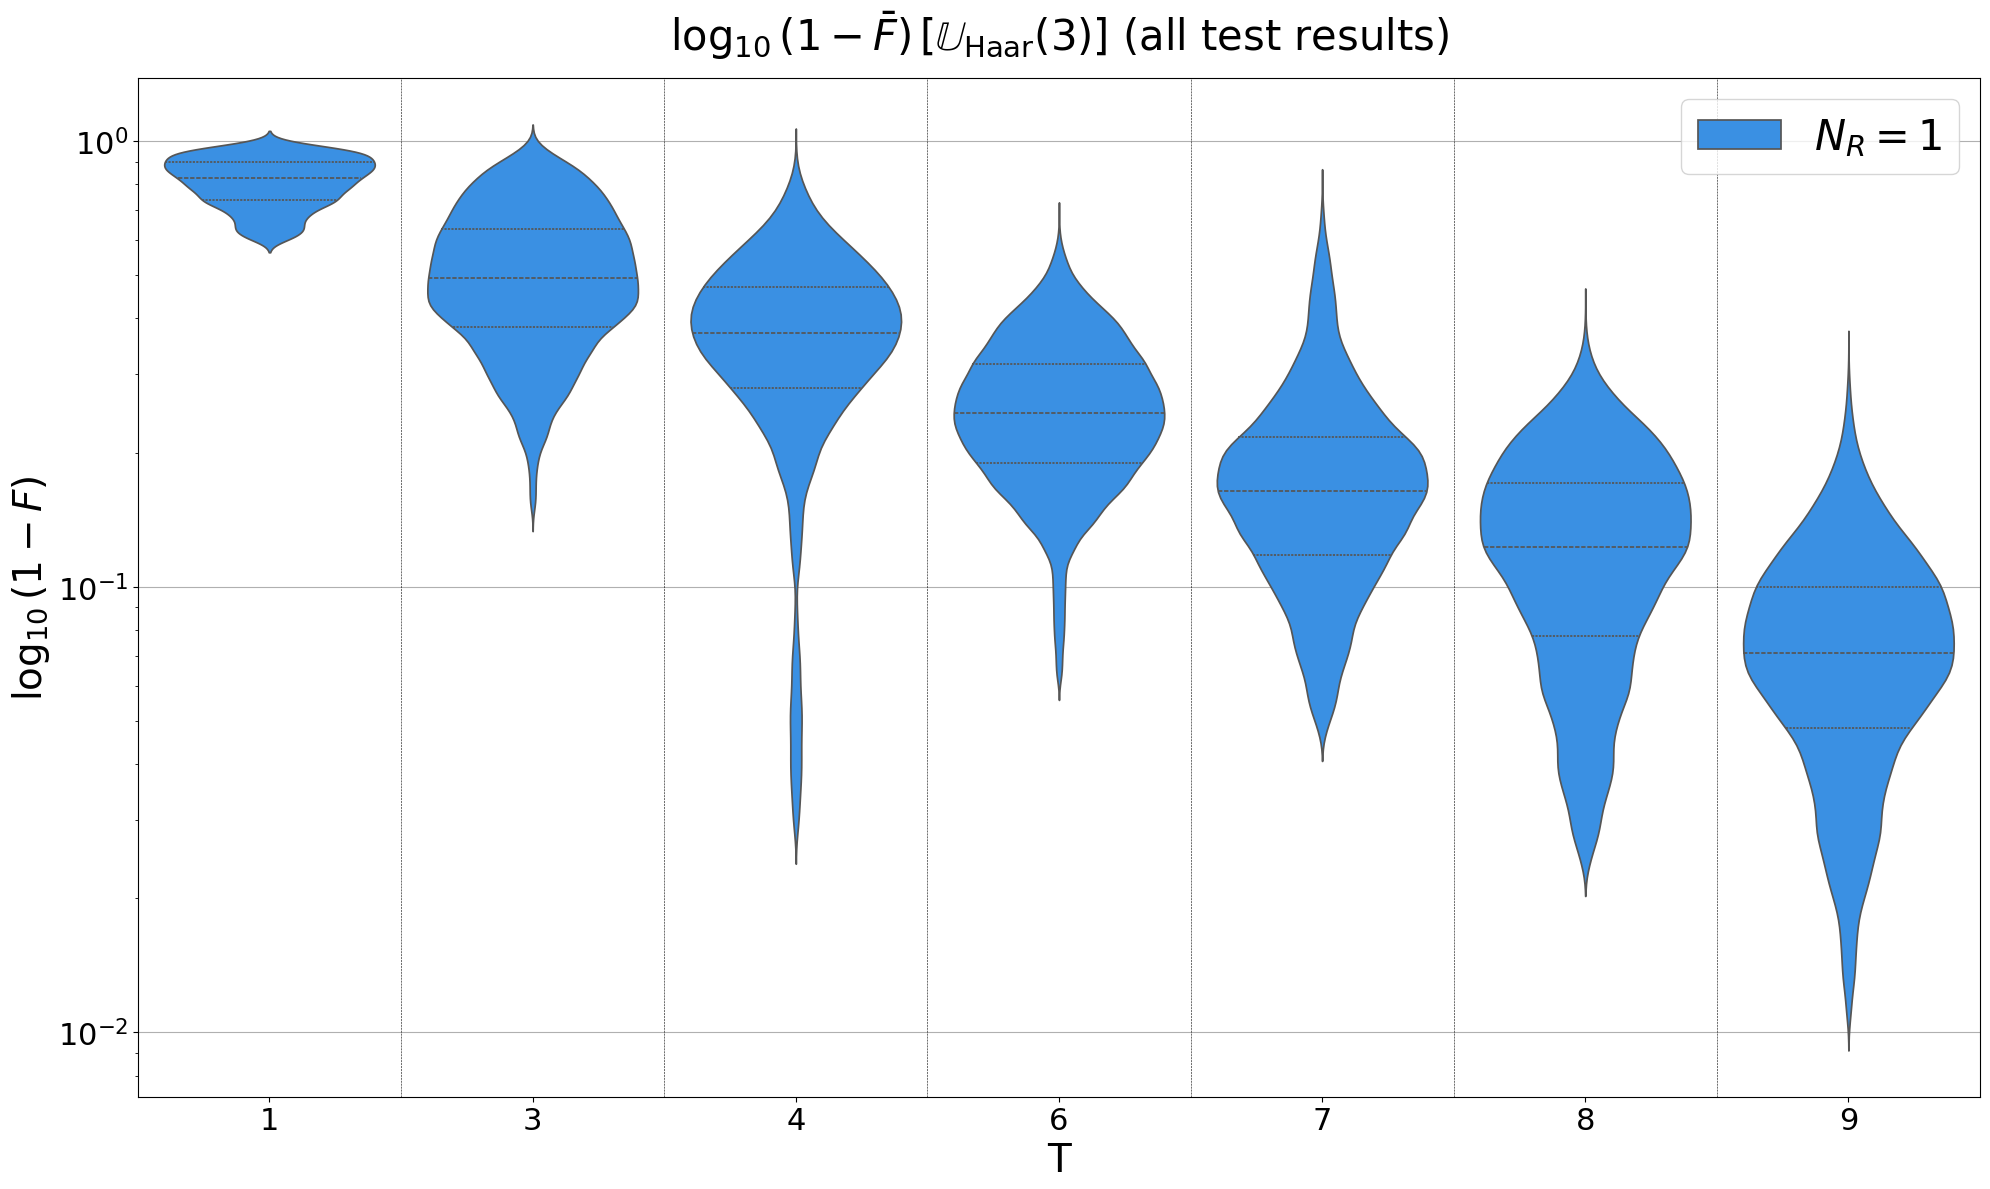

In [11]:
def plot_all_results_error(data_to_plot,
    NC , 
    resies, 
    trots, 
    plot_type='violin', 
    k_depth='trustworthy', 
    custom_palette = 'Set2',
    xlabel = 'T',
    ylabel = r'log(Infidelity)',
    show_labels = False
    ):
    # ------------------------------
    # 1) Subset your DataFrame
    # ------------------------------
    data_df = data_to_plot[(data_to_plot['N_C'] == NC) & (data_to_plot['Trotter_Step'].isin(trots))]
    data_df = data_df[data_df['N_R'].isin(resies)]

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = data_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    test_results_df = data_df[data_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Explode the list of infidelities so each entry is a row
    test_results_df = test_results_df.explode('infidelities')
    test_results_df = test_results_df.dropna(subset=['infidelities'])

    # ------------------------------
    # 2) Set up the Plot
    # ------------------------------

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))

    # Use order=... to ensure Trotter steps appear in sorted order
    sorted_steps = sorted(test_results_df['Trotter_Step'].unique())
    if plot_type == 'boxen':
        sns.boxenplot(
                x='Trotter_Step',
                y='infidelities',
                hue='N_R',
                data=test_results_df,
                ax=ax,
                palette=custom_palette,
                k_depth=k_depth,
                showfliers=True,
                log_scale=True,
                width=.9,
                gap=0.2,
                zorder=2
            )
    else:
        sns.violinplot(
            x='Trotter_Step',
            y='infidelities',
            hue='N_R',
            data=test_results_df,
            ax=ax,
            palette=custom_palette,
            log_scale=True,             # log-scale on the y-axis
            density_norm='width',
            inner='quartile',
            saturation=0.75,
            order=sorted_steps          # ensure sorted categories
        )

    # ------------------------------
    # 3) Customize the Axes/Legend
    # ------------------------------
    ax.set_title(
        f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$ (all test results)',
        fontsize=30, 
        pad=20
    )
    ax.set_xlabel(xlabel, fontsize=28)
    ax.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    ax.set_axisbelow(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[:2],
        [f'$N_R = {label}$' for label in labels[:2]],
        title_fontsize=16,
        ncol=len(labels),
        loc='upper right',
        fontsize=30
    )

    yticks = ax.get_yticklabels()
    # print(yticks)
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    # Use unique Trotter_Steps to match the sorted steps for vertical lines
    unique_x_ticks = sorted(test_results_df['Trotter_Step'].unique()) 
    print(unique_x_ticks)
    positions = range(1, len(unique_x_ticks), 1)
    for pos in positions:
        ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
    ymin, ymax = ax.get_ylim()

    # If data never dips below 1e-12 or above 1e+4, Seaborn won't label them by default,
    # but we can force them to appear by enumerating all exponents.
    lowest_exp = int(np.floor(np.log10(ymin))) + 1
    highest_exp = int(np.ceil(np.log10(ymax)))

    # Build a list of all 10^exponent for each integer exponent in this range
    print(f"highest_exp: {highest_exp}, {lowest_exp}")
    exponents = range(lowest_exp, highest_exp)
    all_ticks = [10**e for e in exponents]

    # Apply them as your new ticks
    ax.set_yticks(all_ticks)
    ax.set_yticklabels([f'$10^{{{e}}}$' for e in exponents], fontsize=22)

    if not show_labels:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(None)
    # ------------------------------
    # 4) Final Layout and Show
    # ------------------------------
    plt.tight_layout()
    plt.show()

custom_palette = ['dodgerblue', 'gold', 'violet'] 
NC = 2
resies = [1]
trots = [1,2,3,4,5,6,7,8,9]
plot_all_results_error(all_data_df,
    NC=NC,
    resies=resies,
    trots=trots,
    custom_palette=custom_palette,
    show_labels=True
    )

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_81350/1760474057.py:48: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


ymin, ymax: -0.04554558244129706, 1.038800156560878


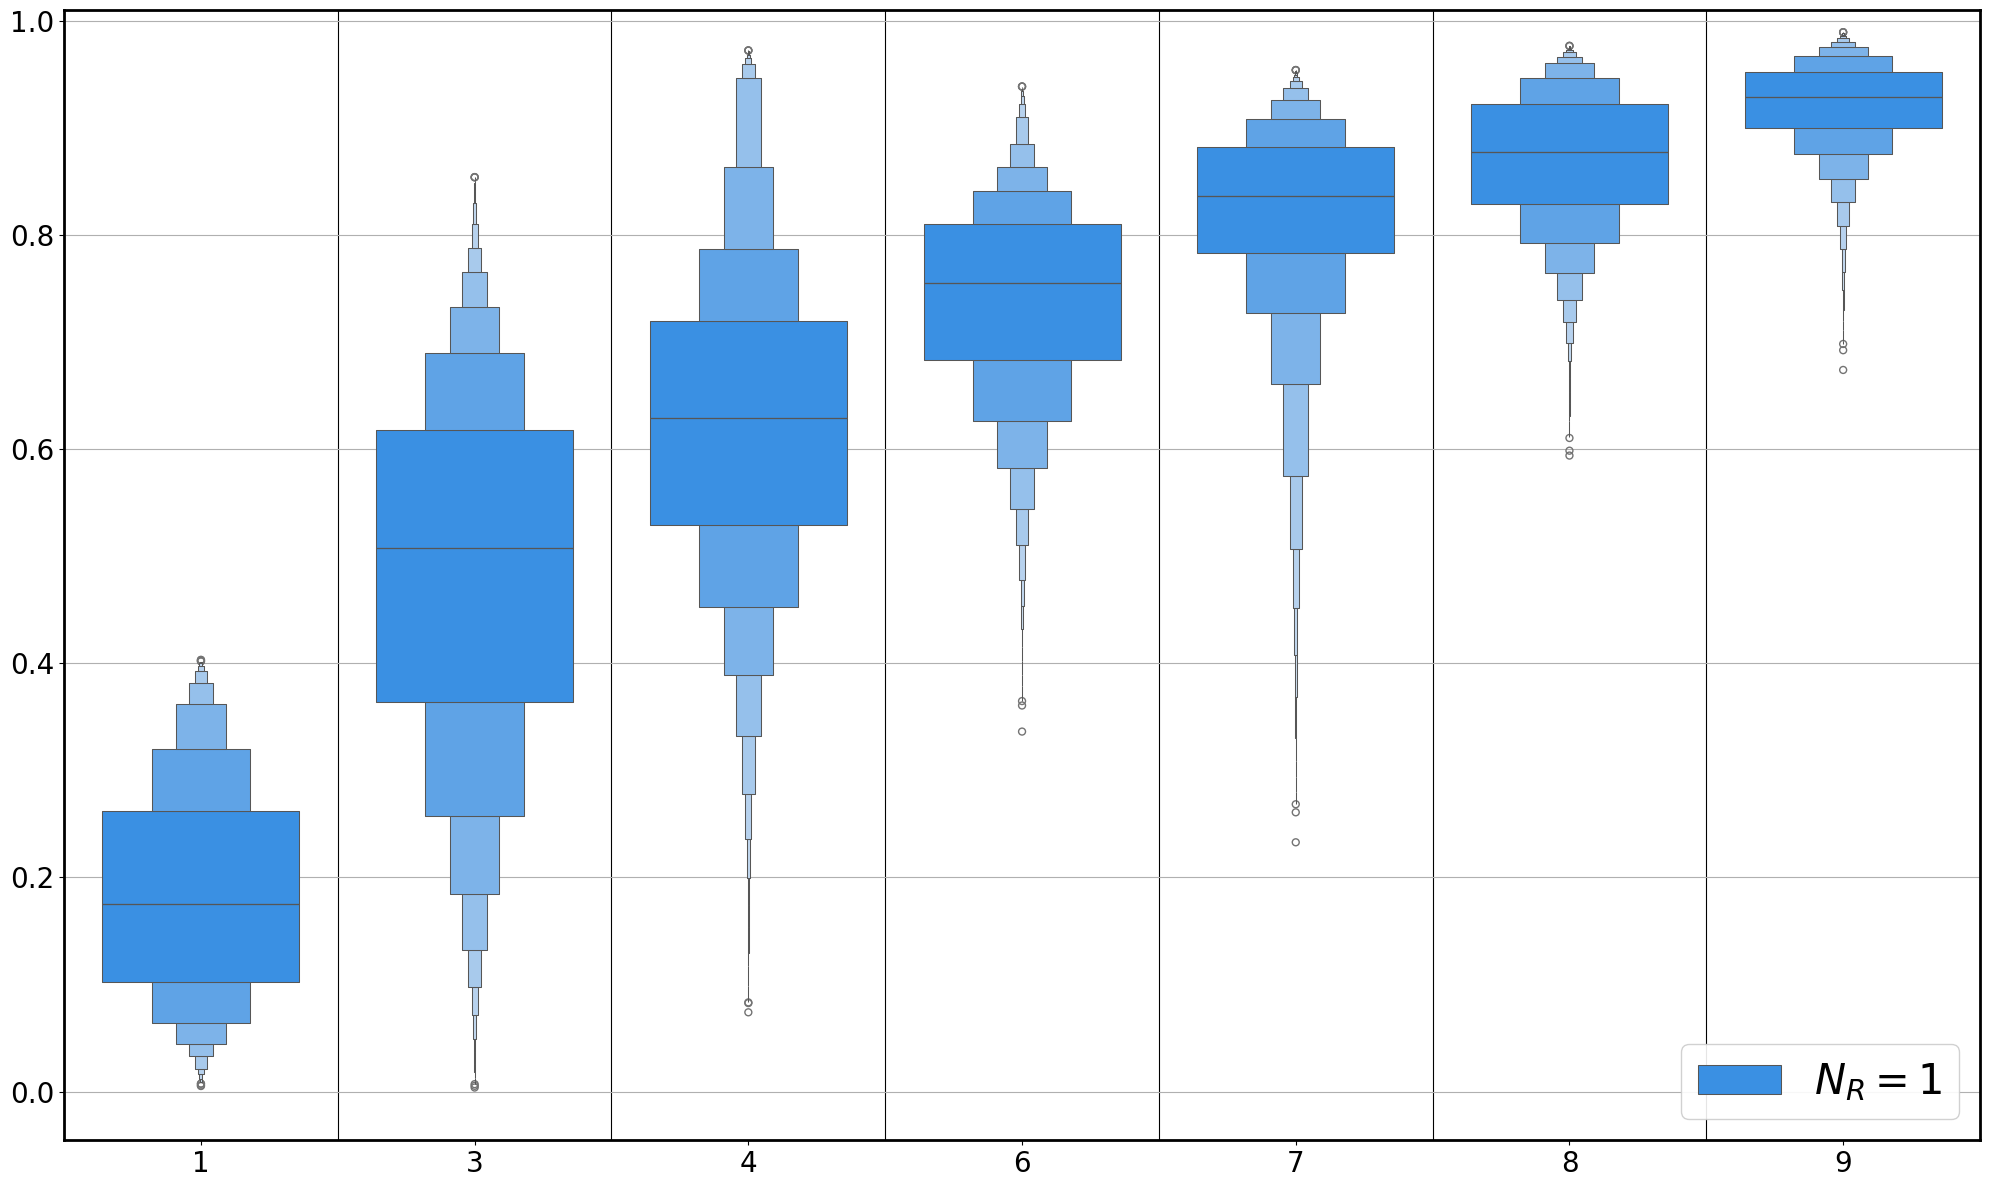

In [12]:
def plot_fidelity_all(data_df, N_C,resies, trotter_steps=None, plot_type = "boxen", k_depth="trustworthy",whis=(0,100),custom_palette='Set2',
xlabel = 'T',
ylabel = r'log(Infidelity)',
show_labels = False
):
    df_to_plot = data_df[data_df['N_C'] == N_C]
    if trotter_steps:
        df_to_plot = df_to_plot[df_to_plot['Trotter_Step'].isin(trotter_steps)]
    df_to_plot = df_to_plot[df_to_plot['N_R'].isin(resies)]


    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = df_to_plot.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    test_results_df = df_to_plot[df_to_plot['Trotter_Step'].isin(valid_trotter_steps)]

    # Explode the list of infidelities so each entry is a row
    test_results_df = test_results_df.explode('fidelities')
    test_results_df = test_results_df.dropna(subset=['fidelities'])

    # ------------------------------
    # 2) Set up the Plot
    # ------------------------------

    fig, axs = plt.subplots(1, 1, figsize=(20, 12))
    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    axs.set_title(
        f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$ (avged)',
        fontsize=30, 
        pad=20
    )
    axs.set_xlabel(xlabel, fontsize=28)
    axs.set_ylabel(f'$\\bar{{F}}$', fontsize=28)

    # Add vertical strips of color for trotter steps
    unique_trotter_steps = sorted(test_results_df['Trotter_Step'].unique())
    positions = range(1, len(unique_trotter_steps) + 1)
    for i, pos in enumerate(positions):
        axs.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)
   
    # Use order=... to ensure Trotter steps appear in sorted order
    sorted_steps = sorted(test_results_df['Trotter_Step'].unique())
    if plot_type == "boxen":
        sns.boxenplot(
            x='Trotter_Step',
            y='fidelities',
            hue='N_R',
            data=test_results_df,
            ax=axs,
            palette=custom_palette,
            k_depth=k_depth,
            showfliers=True,
           
            width=0.9,
            gap=0.2,
            zorder=2,
            order=sorted_steps  
        )
    
    elif plot_type=="bar":
        sns.barplot(
            x='Trotter_Step',
            y='fidelities',
            hue='N_R',
            data=test_results_df,
            ax=axs,
            gap=.2, 
            
            
            palette=custom_palette,

            zorder=2,
            order=sorted_steps  
        )
  
    

    # axs.yaxis.grid(True)
    # axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    handles, labels = axs.get_legend_handles_labels()
    axs.legend(
        handles,
        [f'$N_R = {label}$' for label in labels],
        loc='lower right',
        ncol=len(labels),
        fontsize=30,fancybox=True,
        framealpha=0.9
    )
    # axs.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.9)

    # Customize grid and title
    axs.yaxis.grid(True, zorder=1)
    axs.xaxis.grid(False)
    

    if not show_labels:
        axs.set_xlabel(None)
        axs.set_ylabel(None)
        axs.set_title(None)

    ymin, ymax = axs.get_ylim()
    axs.set_ylim(ymin,1.01)
    
    print(f"ymin, ymax: {ymin}, {ymax}")

    # exponents = range(lowest_exp, highest_exp)
    # all_ticks = [10**e for e in exponents]

    # # Apply them as your new ticks
    # axs.set_yticks(all_ticks)
    # axs.set_yticklabels([f'$10^{{{e}}}$' for e in exponents], fontsize=22)


    # Adjust tick sizes
    axs.tick_params(axis='y', labelsize=20)
    axs.tick_params(axis='x', labelsize=20)

    plt.tight_layout()
    plt.show()
def plot_avg_fidelity(data_df, N_C,resies, trotter_steps=None, plot_type = "boxen", k_depth="trustworthy",whis=(0,100),custom_palette='Set2',
    xlabel = 'T',
    ylabel = r'log(Infidelity)',
    show_labels = False
    ):


    # Filter data by N_C
    df_to_plot = data_df[data_df['N_C'] == N_C]

    # Filter by trotter_steps
    if trotter_steps:
        df_to_plot = df_to_plot[df_to_plot['Trotter_Step'].isin(trotter_steps)]
    df_to_plot = df_to_plot[df_to_plot['N_R'].isin(resies)]

    fig, axs = plt.subplots(1,  figsize=(22, 14))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    axs.set_title(
        f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$ (avged)',
        fontsize=30, 
        pad=20
    )
    axs.set_xlabel(xlabel, fontsize=28)
    axs.set_ylabel(f'$\log_{{10}}(1 - \\bar{{F}})$', fontsize=28)

    # Add vertical strips of color for trotter steps
    unique_trotter_steps = sorted(df_to_plot['Trotter_Step'].unique())
    positions = range(1, len(unique_trotter_steps) + 1)
    for i, pos in enumerate(positions):
        axs.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)
   
    if plot_type == "boxen":
        sns.boxenplot(
            x='Trotter_Step',
            y='Avg_Fidelity',
            hue='N_R',
            data=df_to_plot,
            ax=axs,
            palette=custom_palette,
            k_depth=k_depth,
            showfliers=True,
           
            width=0.9,
            gap=0.2,
            zorder=2
        )
    
    elif plot_type=="bar":
        sns.violinplot(
            x='Trotter_Step',
            y='Avg_Fidelity',
            hue='N_R',
            data=df_to_plot,
            ax=axs,
            gap=.2, 
            
            density_norm='count',
            
            palette=custom_palette,
            inner="point",
            zorder=2
        )

    # axs.yaxis.grid(True)
    # axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    handles, labels = axs.get_legend_handles_labels()
    axs.legend(
        handles,
        [f'$N_R = {label}$' for label in labels],
        loc='lower right',
        ncol=len(labels),
        fontsize=30,fancybox=True,
        framealpha=0.9
    )
    # axs.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.9)

    # Customize grid and title
    axs.yaxis.grid(True, zorder=1)
    axs.xaxis.grid(False)
    

    if not show_labels:
        axs.set_xlabel(None)
        axs.set_ylabel(None)
        axs.set_title(None)

    ymin, ymax = axs.get_ylim()
    axs.set_ylim(ymin,1.01)
    
    print(f"ymin, ymax: {ymin}, {ymax}")

    # exponents = range(lowest_exp, highest_exp)
    # all_ticks = [10**e for e in exponents]

    # # Apply them as your new ticks
    # axs.set_yticks(all_ticks)
    # axs.set_yticklabels([f'$10^{{{e}}}$' for e in exponents], fontsize=22)


    # Adjust tick sizes
    axs.tick_params(axis='y', labelsize=20)
    axs.tick_params(axis='x', labelsize=20)

    plt.tight_layout()
    plt.show()

trots_plos_low = [1,2,3, 4, 5, 6,7,8,9]
# plot_avg_error(all_data_df,
#     N_C=NC,
#     resies=resies,
#     trotter_steps=trots_plos_low,
#     plot_type="boxen",
#     custom_palette=custom_palette,
#     show_labels=False
#     )
plot_fidelity_all(all_data_df,
    N_C=NC,
    resies=resies,
    trotter_steps=trots_plos_low,
    plot_type="boxen",
    custom_palette=custom_palette,
    show_labels=False
    )